In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/usr/local/python/openpose')
from openpose import *

# OpenPose のパラメータ設定

In [3]:
# Parameters for OpenPose.
# Take a look at C++ OpenPose example for meaning of components.
# Ensure all below are filled
params = dict()
params["logging_level"] = 3
params["output_resolution"] = "-1x-1"
params["net_resolution"] = "-1x368"
params["model_pose"] = "BODY_25"
params["alpha_pose"] = 0.6
params["scale_gap"] = 0.3
params["scale_number"] = 1
params["render_threshold"] = 0.05
# If GPU version is built, and multiple GPUs are available, set the ID here
params["num_gpu_start"] = 0
params["disable_blending"] = False
# Ensure you point to the correct path where models are located
#params["default_model_folder"] = dir_path + "/../../../models/"
params["default_model_folder"] = "/home/takataka/180929/openpose/models/"

In [4]:
# Construct OpenPose object allocates GPU memory
openpose = OpenPose(params)

# 画像読み込み

In [45]:
root_dir = pathlib.Path("data/fashion550k").resolve()
img_dir_path = root_dir / "photos"
img_dir_path = img_dir_path / "100"
img_dir_path.exists()

True

In [36]:
img_list = list(img_dir_path.glob("*.jpg"))
len(img_list)

4083

In [40]:
# 画像読み込み
img = cv2.cvtColor(cv2.imread(str(img_list[0])), cv2.COLOR_BGR2RGB)
# Output keypoints and the image with the human skeleton blended on it
keypoints, output_image = openpose.forward(img, True)

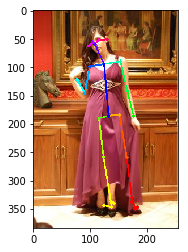

In [41]:
plt.imshow(output_image)

In [42]:
# keypoint を確認
print("keypoint num:", keypoints.shape[1])
keypoints[:,:,2]

keypoint num: 25


array([[0.79730093, 0.76007986, 0.63401955, 0.28121355, 0.09003982,
        0.74003506, 0.7303606 , 0.7946027 , 0.46668482, 0.46899116,
        0.3620848 , 0.3254872 , 0.4312208 , 0.44504306, 0.38483033,
        0.8171457 , 0.8847102 , 0.08611488, 0.7835949 , 0.26354358,
        0.33035085, 0.23138508, 0.18826878, 0.19568193, 0.26014456]],
      dtype=float32)

In [43]:
keypoints[0, -1]

array([1.4238889e+02, 3.3974741e+02, 2.6014456e-01], dtype=float32)

# マップ上に可視化

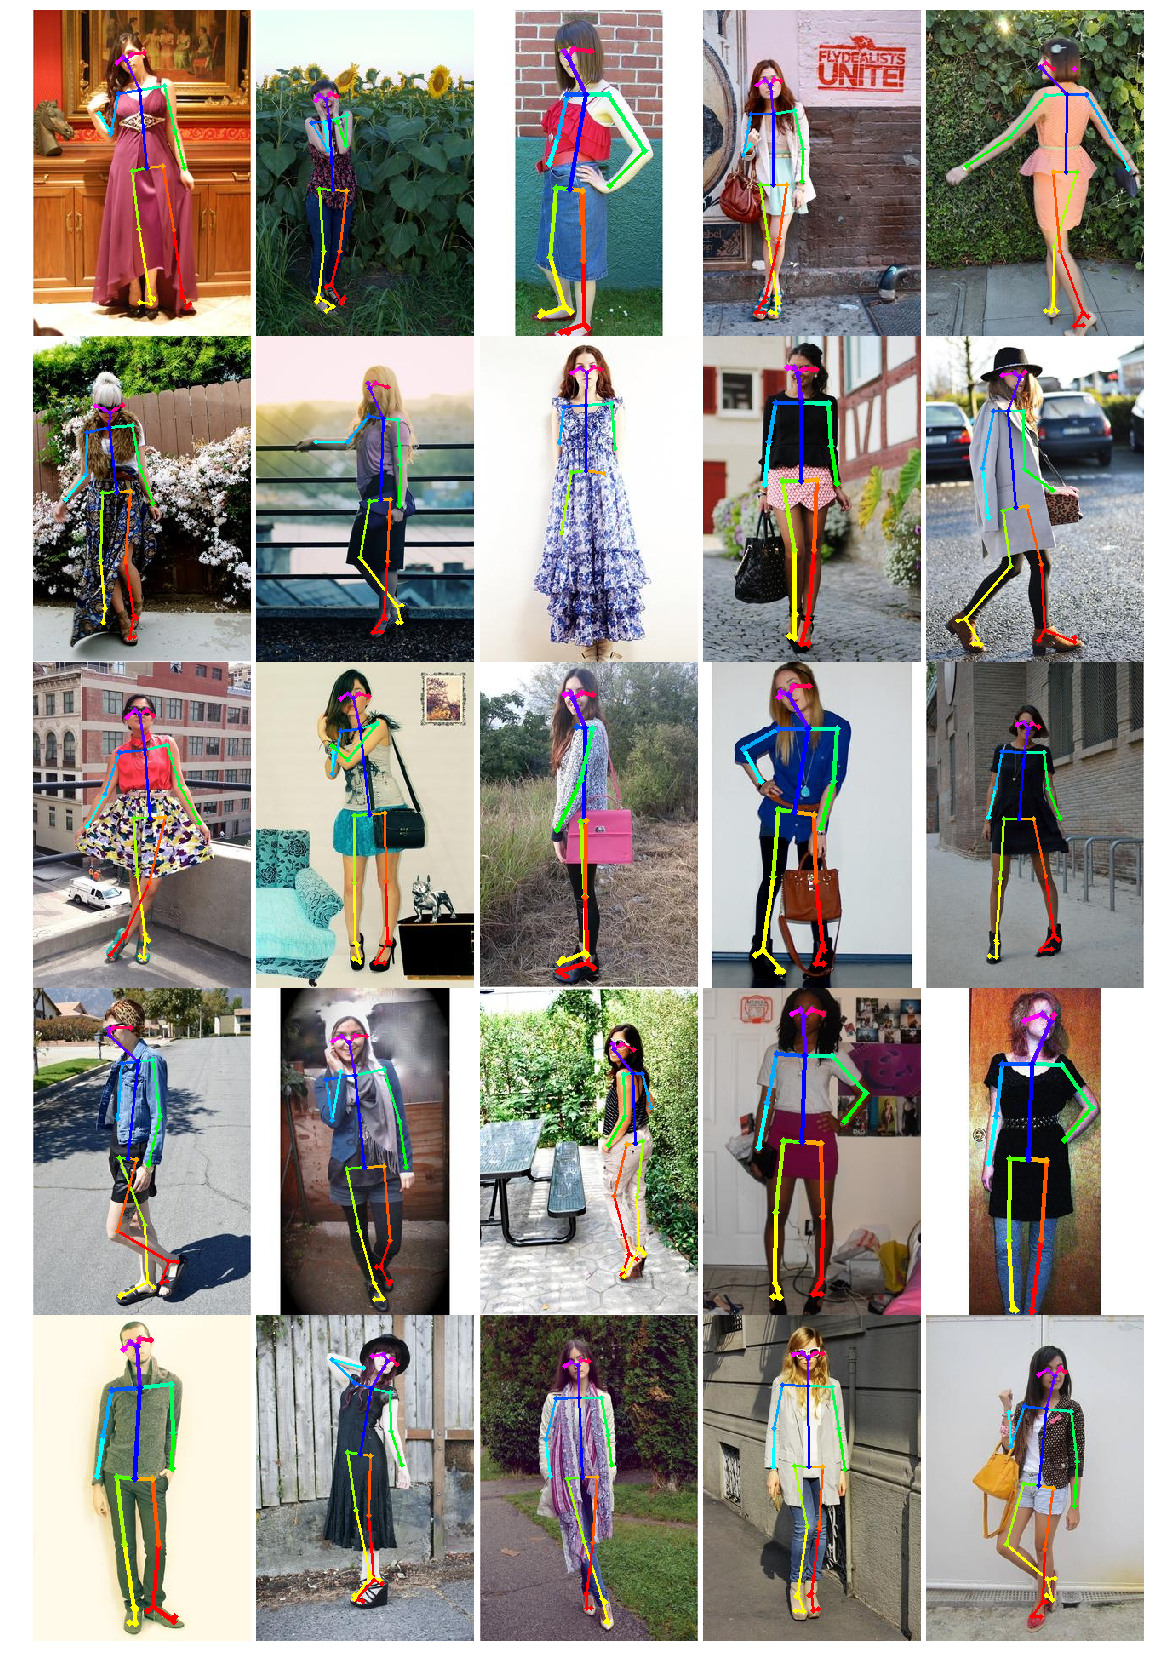

In [27]:
fig, axes = plt.subplots(5, 5, figsize=(20, 30))
for path, ax in zip(img_list, axes.flatten()):
    img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
    keypoints, output_image = openpose.forward(img, True)
    ax.imshow(output_image)
    ax.set_axis_off()
plt.subplots_adjust(hspace=0, wspace=0)
fig.savefig("example_openpose.png", pad_inches=0, bbox_inches="tight")

In [44]:
# 膝から下を推定できていない，７番目のデータのキーポイントリストがどうなっているかをみてみる
img = cv2.cvtColor(cv2.imread(str(img_list[7])), cv2.COLOR_BGR2RGB)
keypoints, output_image = openpose.forward(img, True)
keypoints # 0になっている．

array([[[1.25306946e+02, 4.42195129e+01, 7.03550041e-01],
        [1.24223495e+02, 8.16089554e+01, 5.78813672e-01],
        [9.75604324e+01, 8.37230453e+01, 5.31454921e-01],
        [9.33150024e+01, 1.26396049e+02, 1.64917022e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.54110199e+02, 8.04964142e+01, 3.86432946e-01],
        [1.58422729e+02, 1.32796951e+02, 1.15135573e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.24288559e+02, 1.59468658e+02, 1.81215331e-01],
        [1.07172775e+02, 1.60532791e+02, 1.72541142e-01],
        [9.54477463e+01, 2.32010056e+02, 7.68078938e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.44512421e+02, 1.61592560e+02, 1.63493142e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.16826843e+02, 3.78007622e+01, 7.33174205e-01],
        [1.32748291e+02, 3.67931252e+01, 7.30103731e-01],
        [1.072

# 足まで写っているかどうかを推定
足に注目し，足より上の部分は推定されなくても除外しないことにする．  
以下の２つの選択でまずはデータを選択し，データ数とそのデータの平均画像をとる．

写っているかどうかの判断基準は確信度が0以上かどうか．つまり，閾値は0


1. 足が太ももまで（keypoint でいうと10, 13まで）写っているかどうか

1. 足首まで（keypoint でいうと11, 14まで）写っているかどうか

## RKnee, LKnee まで

In [48]:
img_list = list(img_dir_path.glob("*.jpg"))
len(img_list)

4083

In [56]:
# 画像読み込み
img = cv2.cvtColor(cv2.imread(str(img_list[0])), cv2.COLOR_BGR2RGB)
# Output keypoints and the image with the human skeleton blended on it
keypoints, output_image = openpose.forward(img, True)
hoge = keypoints[:, [10, 13], :]

In [66]:
np.prod(hoge[:, :, 2] > 0, axis=1)

array([1])

In [68]:
position = [10, 11, 24, 23, 22, 13, 14, 19, 21, 20]  # 膝より下に注目．
# 画像読み込み
img = cv2.cvtColor(cv2.imread(str(img_list[0])), cv2.COLOR_BGR2RGB)
# Output keypoints and the image with the human skeleton blended on it
keypoints, output_image = openpose.forward(img, True)
hoge = keypoints[:, position, :]

In [69]:
np.prod(hoge[:, :, 2] > 0, axis=1)

array([1])